# Entrega 3

Ao decorrer do que será apresentado aqui, a justificativa para cada uma das respostas será mais aprofundada, mas até lá, uma breve explicação destas será dada logo abaixo:

#### Utilizar Regressão ou Classificação?
Devido ao fato de ser uma análise e previsão de valores numéricos, e não valores alvos como classes, necessitamos utilizar **Regressões**.

#### Que variáveis e transformações foram utilizadas?
Na subseção Data Cleasing está elucidado como foi feito e onde foi feito cada transformação. Um breve resumo será explicado aqui:

- Ajuste de Types
	- Runtime: str -> int
	- Released_Year: str - int
	- Gross: str -> int

- Tratamento de valores faltantes
	- Certificate: Valor mais frequente
	- Gross: Média
	- Meta_score: Média
- Codificação de variáveis categóricas
	- Genre: Dividida em uma coluna por gênero
	- Actors: Feito a partir de Star1, Star2, Star3 e Star4. Não utilizado por aumentar demais número de features   
	- Director: Dividido em uma coluna por diretor
	- Certificate: Dividodo em uma coluna por classificação etária
- Remoção de colunas desnecessárias
    - Unnamed: 0
    - Genre
    - Star1
    - Star2
    - Star3
    - Star4
    - Certificate
    - Director
    - Series_Title
    - Overview

#### Qual modelo melhor se aproxima dos dados e quais seus prós e contras?
Foram utilizados os seguintes modelos:
- Dummy Regressor
- Linear Regressor
- Decision Tree
- Random Forest
- KNN
- XGB
- LGBM

O modelo que demonstrou a melhor performance foi o **LGBM**.

**LightGBM** é uma técnica de árvores de decisão que opera gerando árvores com mais folhas e menor profundidade com crescimento não uniforme por nível. Permite que o algoritmo seja mais rápido e consuma menos memórias em comparação com outros modelos Boosting.

Possui como **vantagens** sua velocidade, ser altamente escalável (lida bem com grandes volumes de dados) e tende a ser um modelo bastante preciso. Possui como **desvantagens** um ajuste de parametros custoso e suscetibilidade a overfitting.


#### Qual medida de performance do modelo foi escolhida e por quê?
As métricas utilizadas para avaliar a performance do modelo foram:


- **R² (Coeficiente de Determinação)**

- **MAE (Erro Absoluto Médio)**

- **MSE (Erro Quadrático Médio)**

- **RMSE (Raiz do Erro Quadrático Médio)**

- **MAPE (Erro Percentual Absoluto Médio)**

- **Tempo de execução**


Embora todas tenham sua importância,foram amis considerados os valores de **MAE** que indica o quanto o valor previsto se distancia do valor real, **R²** que indica o quanto da variabilidade da nota IMDB é explicada pelo modelo.

## Importando Bibliotecas

In [4]:
# Importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pickle

import warnings


# Definindo formato e tamanho de gráficos 
sns.set_theme(style="darkgrid", rc={'figure.figsize':(10,6)})

## Obtendo o DataFrame

Nesta etapa:

- O Dataset será importado.
- Será adicionado a instância referente a **Entrega 4**, para efetuar as transformações e facilitar o processo de previsão no final do projeto. 

In [7]:
IMDB_PATH = "../datasets/desafio_indicium_imdb.csv"

df = pd.read_csv(IMDB_PATH)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In [9]:
# Criação e Insersão da nova linha referente a Entrega 4
new_row_dict = {'Unnamed: 0': 1000.0,
                'Series_Title': 'The Shawshank Redemption',
                'Released_Year': '1994',
                'Certificate': 'A',
                'Runtime': '142 min',
                'Genre': 'Drama',
                'IMDB_Rating': 9.3,
                'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
                'Meta_score': 80.0,
                'Director': 'Frank Darabont',
                'Star1': 'Tim Robbins',
                'Star2': 'Morgan Freeman',
                'Star3': 'Bob Gunton',
                'Star4': 'William Sadler',
                'No_of_Votes': 2343110,
                'Gross': '28,341,469'}

new_row_df = pd.DataFrame([new_row_dict])

df = pd.concat([df, new_row_df], ignore_index=True)
df

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1.0,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2.0,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3.0,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4.0,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5.0,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996.0,Giant,1956,G,201 min,"Drama, Western",7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,34075,NaN
996,997.0,From Here to Eternity,1953,Passed,118 min,"Drama, Romance, War",7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,"30,500,000"
997,998.0,Lifeboat,1944,NaN,97 min,"Drama, War",7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,NaN
998,999.0,The 39 Steps,1935,NaN,86 min,"Crime, Mystery, Thriller",7.6,A man in London tries to help a counter-espion...,93.0,Alfred Hitchcock,Robert Donat,Madeleine Carroll,Lucie Mannheim,Godfrey Tearle,51853,NaN


Obs: Foram inseridos a coluna "Unnamed: 0" e "IMDB_Rating" na nova linha para comparações posteriores.

## Data Cleansing

Como a explicação de por que e como foi feita a limpeza no arquivo `EDA.ipynb`, aqui serão feitos de forma mais direta

### Ajustando Types

#### Ajustando coluna "Runtime"

In [15]:
# Removendo das colunas o valor " min" e convertendo para int
df["Runtime"] = df["Runtime"].str.replace(" min", "")
df["Runtime"] = df["Runtime"].astype(int)

#### Ajustando coluna "Released_Year"

In [17]:
# Substituindo os valores de PG para 1995
df['Released_Year'] = df['Released_Year'].replace('PG', '1995')

# Conferindo se o valor foi alterado corretamente
df[df['Series_Title'] == 'Apollo 13']

# Convertendo o tipo para int
df["Released_Year"] = df["Released_Year"].astype(int)

#### Ajustando coluna "Gross"

In [19]:
# Removendo das colunas o caractere "," e convertendo para float
df["Gross"] = df["Gross"].str.replace(",", "")
df["Gross"] = df["Gross"].astype(float)

### Tratamento de valores faltantes

#### Tratamento de valores categóricos faltantes

In [22]:
df["Certificate"] = df["Certificate"].fillna(df['Certificate'].mode()[0])

#### Tratamento de valores numéricos faltantes

In [24]:
df["Gross"] = df["Gross"].fillna(df["Gross"].mean())
df["Meta_score"] = df["Meta_score"].fillna(df['Meta_score'].mean())

### Transformação de categorias em variáveis binárias

#### Codificação da coluna "Genre"

In [27]:
# Coluna original "Genre" como listas
multi_genre_list = df["Genre"].str.split(", ")

# Utilizaão do MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(multi_genre_list)

# Criação de lista de gêneros únicos
genres_list = mlb.classes_.tolist()

# Criação de DataFrame de Genres
df_genre = pd.DataFrame(genres_encoded, columns = mlb.classes_, index = df.index)

# Concatenação do DataFrame original + DataFrame de Genres
df = pd.concat([df, df_genre], axis=1)

#### Codificação da coluna "Actors"

Esta etapa precisou ser ignorada. Embora o maior número de dados pudesse auxiliar na análise, o aumento foi muito grande (mais de 2700 colunas a mais), impedindo o processamento dos dados para modelagem e treinamento.

In [30]:
# Separando atores
# actor_cols = ["Star1", "Star2", "Star3", "Star4"]

# selected_actors_list = df[actor_cols].values.tolist()

# mlb = MultiLabelBinarizer()
# df_actors_enconded = pd.DataFrame(mlb.fit_transform(selected_actors_list), columns=mlb.classes_, index=df.index)

# df_actors_enconded.head()

#### Codificação da coluna "Director"

In [32]:
# Separando diretores
df_director_encoded = pd.get_dummies(df['Director'], dtype=int)
df_director_encoded.head()

,Aamir Khan,Aaron Sorkin,Abdellatif Kechiche,Abhishek Chaubey,Abhishek Kapoor,Adam Elliot,Adam McKay,Aditya Chopra,Aditya Dhar,Akira Kurosawa,...,Yilmaz Erdogan,Yimou Zhang,Yoshiaki Kawajiri,Yoshifumi Kondô,Yôjirô Takita,Zack Snyder,Zaza Urushadze,Zoya Akhtar,Çagan Irmak,Ömer Faruk Sorak
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Codificação da coluna "Certificate"

In [34]:
# Separando categorias
df_certificate_encoded = pd.get_dummies(df['Certificate'], dtype=int)
df_certificate_encoded.head()

,16,A,Approved,G,GP,PG,PG-13,Passed,R,TV-14,TV-MA,TV-PG,U,U/A,UA,Unrated
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [35]:
df_combined = pd.concat([df, df_director_encoded], axis=1)
df_combined = pd.concat([df_combined, df_certificate_encoded], axis=1)

### Removendo colunas desnecessárias

In [37]:
df_combined = df_combined.drop(columns=["Unnamed: 0", "Genre", "Star1", "Star2", "Star3", "Star4", "Certificate", "Director", "Series_Title", "Overview"])
df_combined.head()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,Action,Adventure,Animation,Biography,...,PG-13,Passed,R,TV-14,TV-MA,TV-PG,U,U/A,UA,Unrated
0,1972,175,9.2,100.0,1620367,134966411.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2008,152,9.0,84.0,2303232,534858444.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1974,202,9.0,90.0,1129952,57300000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1957,96,9.0,96.0,689845,4360000.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2003,201,8.9,94.0,1642758,377845905.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0


### Analisando valores pós Data Cleansing

In [39]:
df_combined.isnull().sum()

Released_Year    0
Runtime          0
IMDB_Rating      0
Meta_score       0
No_of_Votes      0
                ..
TV-PG            0
U                0
U/A              0
UA               0
Unrated          0
Length: 591, dtype: int64

In [40]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 591 entries, Released_Year to Unrated
dtypes: float64(3), int32(587), int64(1)
memory usage: 2.3 MB


Antes de fazer a divisão Train Test Split, removeremos e salvaremos para a Entrega 4 a última linha

In [42]:
prediction_test = df_combined.iloc[[-1]]
prediction_test

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,Action,Adventure,Animation,Biography,...,PG-13,Passed,R,TV-14,TV-MA,TV-PG,U,U/A,UA,Unrated
999,1994,142,9.3,80.0,2343110,28341469.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df_combined = df_combined.drop(df_combined.index[-1])
df_combined.tail()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,Action,Adventure,Animation,Biography,...,PG-13,Passed,R,TV-14,TV-MA,TV-PG,U,U/A,UA,Unrated
994,1961,115,7.6,76.0,166544,6.803475e+07,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
995,1956,201,7.6,84.0,34075,6.803475e+07,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,1953,118,7.6,85.0,43374,3.050000e+07,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
997,1944,97,7.6,78.0,26471,6.803475e+07,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
998,1935,86,7.6,93.0,51853,6.803475e+07,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Train Test Split

Os dados foram divididos da seguinte forma:

- A classe de interesse (`IMDB_Rating`) foi separada em **y** e as demais em **X**
- A divisão foi feita na proporção de 80-20 devido ao baixo volume de dados

In [46]:
y = df_combined["IMDB_Rating"]
X = df_combined.drop("IMDB_Rating", axis = 1)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

`KFold` é usado para dividir os dados em K partes (folds) para realizar a validação cruzada.

In [49]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

## Avaliando Modelos

Serão então testados 7 modelos diferentes para avaliar seu desempenho:

- **Dummy Regressor**
- **Linear Regressor**
- **Decision Tree**
- **Random Forest**
- **KNN**
- **XGB**
- **LGBM**

Métricas avaliadas nos modelos de regressão: 

- **R² (Coeficiente de Determinação)**: Mede a proporção da variabilidade da variável alvo que é explicada pelo modelo. Varia entre -∞ e 1, sendo que valores próximos de 1 indicam um bom ajuste.

- **MAE (Erro Absoluto Médio)**: Média da magnitude dos erros absolutos. Indica em média o quanto o modelo erra, na mesma unidade da variável de interesse. Quanto menor, melhor.

- **MSE (Erro Quadrático Médio)**: Média dos erros ao quadrado. Penaliza mais fortemente erros grandes, mas perde em interpretabilidade, já que fica em unidades ao quadrado.

- **RMSE (Raiz do Erro Quadrático Médio)**: Raiz quadrada do MSE, voltando à mesma escala da variável alvo. Assim como o MSE, é sensível a outliers, mas mais interpretável.

- **MAPE (Erro Percentual Absoluto Médio)**: Média dos erros em termos percentuais. Indica o quanto, em média, o modelo erra proporcionalmente ao valor verdadeiro. Não é adequado quando há valores próximos de zero.

In [53]:
MODELS_REG = {
    "Dummy": DummyRegressor(),
    "Linear": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "KNN": KNeighborsRegressor(),
    "XGB": XGBRegressor(),
    "LGBM": LGBMRegressor()
}

SCORING_REG = {
    "R2": "r2",
    "MAE": "neg_mean_absolute_error",
    "MSE": "neg_mean_squared_error",
    "RMSE": "neg_root_mean_squared_error",
    "MAPE": "neg_mean_absolute_percentage_error"
}

In [54]:
def train_model_regression(TRAIN_X: pd.DataFrame, TRAIN_Y, MODELS: dict, CV, SCORING: dict):
    """
    Treina múltiplos modelos de regressão e retorna os resultados em formato de dicionário.

    Parameters
    ----------
    TRAIN_X : pd.DataFrame
        Conjunto de treino (features).
    TRAIN_Y : pd.Series ou np.array
        Target contínuo.
    MODELS : dict
        Dicionário com estimadores de regressão e nomes.
    CV : int, generator ou cross-validation splitter
        Estratégia de validação cruzada.
    SCORING : dict
        Dicionário de métricas de avaliação para regressão.

    Returns
    -------
    dict
        Resultados dos modelos no formato {nome_modelo: dict_de_scores}.
    """

    results = {}

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        for model_name, regressor in MODELS.items():
            results[model_name] = cross_validate(
                estimator = regressor,
                X = TRAIN_X,
                y = TRAIN_Y,
                cv = CV,
                scoring = SCORING,
                return_train_score = False,  # útil para checar overfitting
                n_jobs = -1
            )

    return results

In [55]:
results_reg = train_model_regression(X_train, y_train, MODELS_REG, cv, SCORING_REG)

In [56]:
def results_to_df(model_results, sum_time):
    """
    Converte os resultados dos modelos de treinamento para DataFrame com nome do modelo, divisões e scores.

    Parâmetros
    ----------
    model_results: dict
        Dicionário com resultados de modelos.

    sum_time: bool
        Valor booleano para converter valores de tempo em sua soma.

    Returns
    -------
    pd.DataFrame
        DataFrame com scores dos modelos.
    """
    
    df = pd.DataFrame(model_results).T

    # list of columns
    col_list = df.columns.tolist()
    
    df = df.explode(col_list)
    df = df.reset_index()

    df[col_list] = df[col_list].astype(float)
    df.rename(columns={'index': 'models'}, inplace=True)

    if sum_time:
        df['total_time'] = df['fit_time'] + df['score_time']
        df = df.drop(columns=['fit_time', 'score_time'])
        
    return(df)

Abaixo observamos os valores para cada uma das 5 k folds para cada modelo de teste:

In [58]:
df_results = results_to_df(results_reg, sum_time = True)
df_results

,models,test_R2,test_MAE,test_MSE,test_RMSE,test_MAPE,total_time
0,Dummy,-0.002657,-0.234475,-0.085865,-0.293027,-0.029232,0.015625
1,Dummy,-0.001613,-0.208715,-0.071140,-0.266720,-0.025956,0.015625
2,Dummy,-0.000890,-0.223113,-0.078629,-0.280408,-0.027799,0.015625
3,Dummy,-0.004569,-0.218072,-0.072909,-0.270017,-0.027308,0.015625
4,Dummy,-0.002834,-0.219209,-0.072350,-0.268979,-0.027344,0.015625
5,Linear,0.370268,-0.179277,-0.053928,-0.232225,-0.022542,0.094286
6,Linear,0.225061,-0.174265,-0.055040,-0.234606,-0.021822,0.094286
7,Linear,0.160788,-0.206269,-0.065928,-0.256764,-0.025892,0.078135
8,Linear,0.257593,-0.177791,-0.053882,-0.232125,-0.022287,0.109940
9,Linear,0.284961,-0.180220,-0.051587,-0.227127,-0.022695,0.093767


In [59]:
df_results.groupby("models").mean().sort_values("test_MAE", ascending=False)

,test_R2,test_MAE,test_MSE,test_RMSE,test_MAPE,total_time
models,,,,,,
LGBM,0.545669,-0.147000,-0.034583,-0.185226,-0.018468,0.263278
Random Forest,0.518791,-0.150916,-0.036614,-0.190841,-0.018914,0.992423
XGB,0.478572,-0.156535,-0.039812,-0.198824,-0.019640,0.636505
Linear,0.259734,-0.183565,-0.056073,-0.236569,-0.023047,0.094083
Decision Tree,0.144614,-0.196854,-0.064936,-0.254164,-0.024675,0.025945
Dummy,-0.002513,-0.220717,-0.076178,-0.275830,-0.027528,0.015625
KNN,-0.092013,-0.227416,-0.082887,-0.287765,-0.028345,0.078684


Com isso, podemos ver que o modelo **LGBM** possui o melhor valor de MAE (`test_MAE`) e o melhor valor de R² `test_R2`, portanto, este será o próximo modelo utilizado. Com isso em mente, também analisaremos a distribuição dos valores:

In [61]:
def box_plots(df, x_val, y_val_list):
    """
    Converta os resultados dos modelos de treinamento para DataFrame com nome do modelo, divisões e scorings.

    Parâmetros
    ----------
    df: pd.DataFrame
        DataFrame com scorings.

    x_val: str
        Valor para o x axis.

    y_val_list: list
        Lista de parâmetros e pontuações a serem analisados.

    Returns
    -------
    Graficos
        Boxplots.
    """
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 20), sharex=True)
    axes = axes.flatten()  # Transforma em vetor para facilitar iteração

    for i, y_val in enumerate(y_val_list):
        sns.boxplot(data=df, x=x_val, y=y_val, color='skyblue', showfliers=True, ax=axes[i])
        axes[i].set_title(f'{y_val} Boxplot', fontsize=12)
        axes[i].set_xlabel(x_val)
        axes[i].set_ylabel(y_val)
        axes[i].tick_params(axis="x", rotation=45, labelsize="small")



    # Remove subplots vazios (caso y_val_list tenha menos de 6 elementos)
    for j in range(len(y_val_list), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return(None)

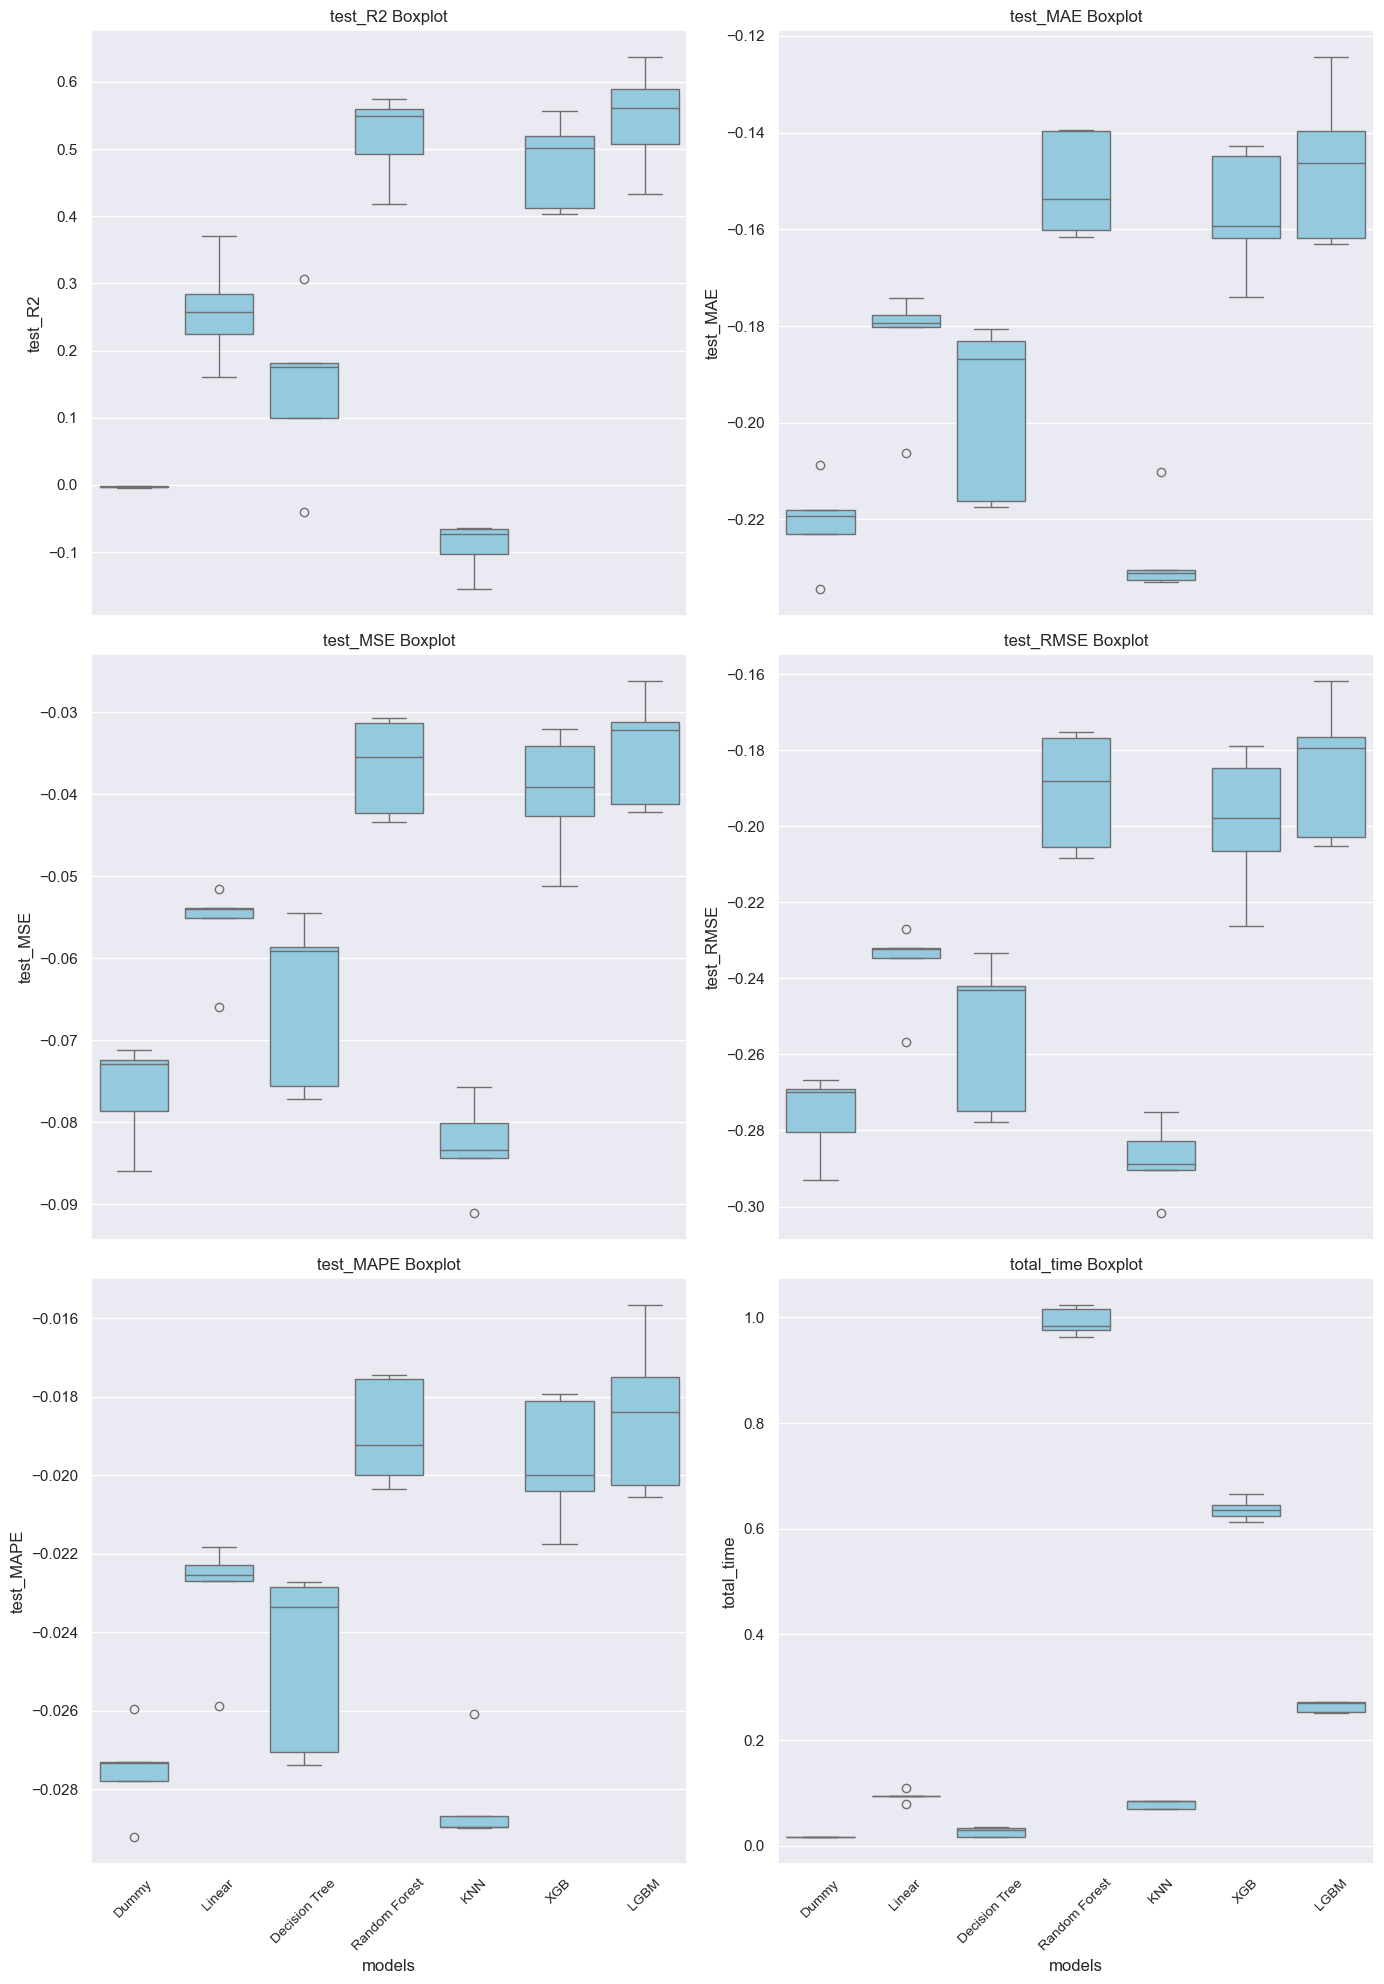

In [62]:
y_list = ["test_R2", "test_MAE", "test_MSE", "test_RMSE", "test_MAPE", "total_time"]
box_plots(df = df_results, x_val= "models", y_val_list = y_list)

Com isso, observamos que o classificador **LGBM** demonstra melhor desempenho em diversos aspectos do que os outros regressores. Na próxima etapa, o modelo será ajustado.

# Entrega 5

## Fine Tunning

Os parâmetros serão submetidos a um Fine Tunning através do `GridSearchCV`, onde a cada iteração para os valores a serem testados o modelo será submetido a um k-fold para evitar possíveis problemas de overfitting. Além disso, os seguintes parâmetros serão destacados:

- Serão implementadas as mesmas métricas que foram utilizadas para avaliar os modelos anteriores.
- O modelo escolhido foi o Classificador **LGBM**.
- 5 hiperparâmetros quando submetidos ao Ajuste, que terão duas variações cada (nos testes anteriores outros hiperparâmetros foram testados, mas devido ao tempo de teste, apenas os que apresentaram o melhor desempenho serão testados)
- A métrica determinante expressa pelo `refit` foi o **MAE**.

In [67]:
# Modelo
lgbm = LGBMRegressor(random_state=42)

# Definir grade de parâmetros para GridSearchCV
param_grid = {
    "n_estimators": [300, 350, 400],
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 3, 5],
    "learning_rate": [0.1, 0.3, 0.5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# GridSearchCV
grid_search_lgbm = GridSearchCV(
    estimator = lgbm,
    param_grid = param_grid,
    scoring = SCORING_REG,          
    refit = "MAE",                  
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

In [68]:
# Ajustando o modelo com dados de treinamento
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    grid_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 799, number of used features: 29
[LightGBM] [Info] Start training from score 7.951439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [69]:
# Resultados
print("best parameters:", grid_search_lgbm.best_params_)
print("best MAE score:", grid_search_lgbm.best_score_)

best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'num_leaves': 31, 'subsample': 0.6}
best MAE score: -0.1451247511163259


### Avaliando Modelos

Após a obtenção dos melhores parâmetros para o modelo, serão então avaliadas as pontuações obtidas através do `GridSearchCV`:

In [72]:
def best_estimator_gs_mean_split_values(GRID_SEARCH: GridSearchCV) -> pd.DataFrame:
    """
    Get mean and splits scores for the best estimator from a GridSearchCV object.

    Parameters
    ----------
    GRID_SEARCH : GridSearchCV
        Fitted GridSearchCV object.

    Returns
    -------
    pd.DataFrame
        DataFrame with mean and splits scores for the best estimator
    """
    
    best_estimator_index = GRID_SEARCH.best_index_
    cv_results = GRID_SEARCH.cv_results_

    mean_scores = {}
    split_scores = {f"split{i}": {} for i in range(5)}

    # Iterar por cada métrica
    for metric in GRID_SEARCH.scoring:
        mean_scores[metric] = cv_results[f"mean_test_{metric}"][best_estimator_index]

        for i in range(5):
            split_scores[f"split{i}"][metric] = cv_results[f"split{i}_test_{metric}"][best_estimator_index]


    df_mean_scores = pd.DataFrame(mean_scores, index=["mean_score"]).T
    df_split_scores = pd.DataFrame(split_scores).T 
    df_split_scores.index.name = "split"

    return df_mean_scores, df_split_scores

In [73]:
df_mean, df_split = best_estimator_gs_mean_split_values(grid_search_lgbm)

In [74]:
df_mean

,mean_score
R2,0.539753
MAE,-0.145125
MSE,-0.033921
RMSE,-0.183841
MAPE,-0.018208


In [75]:
df_split

,R2,MAE,MSE,RMSE,MAPE
split,,,,,
split0,0.616544,-0.149479,-0.034154,-0.184808,-0.018686
split1,0.603367,-0.143257,-0.032312,-0.179755,-0.018017
split2,0.520847,-0.142781,-0.034918,-0.186864,-0.017866
split3,0.504806,-0.132836,-0.027799,-0.166730,-0.016865
split4,0.453200,-0.157271,-0.040421,-0.201050,-0.019605


### Salvando Melhor Modelo

In [77]:
filename = "../models/lgbm_best_model.pkl"

with open(filename, "wb") as f:
    pickle.dump(grid_search_lgbm.best_estimator_, f)

# Entrega 4

Nesta etapa será feita a previsão da nota do filme 'The Shawshank Redemption'. Antes disso, veremos como o modelo está desempenhando no conjunto de testes:

In [80]:
best_lgbm = grid_search_lgbm.best_estimator_

y_pred = best_lgbm.predict(X_test)

In [81]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

R2: 0.412
MAE: 0.151
RMSE: 0.196


Porfim, será prevista a nota do filme 'The Shawshank Redemption'.

In [83]:
X_prediction_test = prediction_test.drop('IMDB_Rating', axis=1)
y_prediction_test = prediction_test['IMDB_Rating']

In [84]:
# Previsão
y_pred_linha = best_lgbm.predict(X_prediction_test)

In [85]:
print(f"Nota real do IMDb: {y_prediction_test}")
print(f"Nota prevista: {y_pred_linha[0]}")

Nota real do IMDb: 999    9.3
Name: IMDB_Rating, dtype: float64
Nota prevista: 8.808332996018425


Conseguimos observar então que, a nota prevista foi 8.8, se aproximando considerávelmente da nota real, 9.3.